In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
from keras.preprocessing import image
import tensorflow


trainPath = '/kaggle/input/gtsrb-german-traffic-sign/Train'

data=[]
labels=[]
dataset_category_count = 0
for dirs in os.listdir(trainPath): #slozky z Train foldery
    #print(dirs)
    for files in os.listdir(trainPath+'/'+ dirs): #obrazek z foldery v kategorii
        try:
            sign_img = np.array(image.load_img(trainPath + "/"+ dirs +"/"+ files, target_size = (32,32)))
            data.append(sign_img) #do seznamu s obrazkovymi daty prida aktualne zpracovany/nacteny obrazek
            labels.append(int(dirs)) #do seznamu s labely prida cislo labelu ve kterem se obrazek nachazi
        except:
            pass
    dataset_category_count += 1
print(str(dataset_category_count))    

43


In [3]:
print(len(data),len(labels))
#popisky obrazku
category_labels = {
    0:"Speed limit (20km/h)",
    1:"Speed limit (30km/h)",
    2:"Speed limit (50km/h)",
    3:"Speed limit (60km/h)",
    4:"Speed limit (70km/h)",
    5:"Speed limit (80km/h)",
    6:"End of speed limit (80km/h)",
    7:"Speed limit (100km/h)",
    8:"Speed limit (120km/h)",
    9:"No passing",
    10:"No passing for vehicles over 3.5 metric tons",
    11:"Right-of-way at the next intersection",
    12:"Priority road",
    13:"Yield",
    14:"Stop",
    15:"No vehicles",
    16:"Vehicles over 3.5 metric tons prohibited",
    17:"No entry",
    18:"General caution",
    19:"Dangerous curve to the left",
    20:"Dangerous curve to the right",
    21:"Double curve",
    22:"Bumpy road",
    23:"Slippery road",
    24:"Road narrows on the right",
    25:"Road work",
    26:"Traffic signals",
    27:"Pedestrians",
    28:"Children crossing",
    29:"Bicycles crossing",
    30:"Beware of ice/snow",
    31:"Wild animals crossing",
    32:"End of all speed and passing limits",
    33:"Turn right ahead",
    34:"Turn left ahead",
    35:"Ahead only",
    36:"Go straight or right",
    37:"Go straight or left",
    38:"Keep right",
    39:"Keep left",
    40:"Roudabout mandatory",
    41:"End of no passing",
    42:"End of no passing by vehicles over 3.5 metric tons",
}
category_labels[0]


39209 39209


'Speed limit (20km/h)'

6399


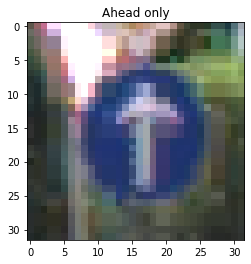

28


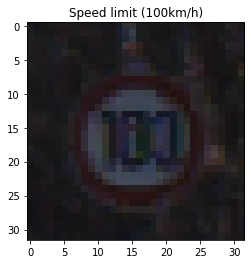

15273


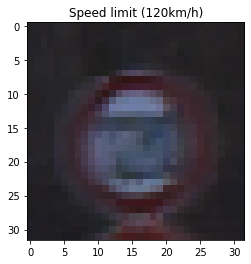

In [4]:
import matplotlib.pyplot as plt
import random

for i in range(3):
    rnd = random.randint(0,len(data))
    print(str(rnd))
    preview = plt.imshow(data[rnd])
    preview_title = plt.title(category_labels[labels[rnd]])
    plt.show()
 

In [5]:
from sklearn.model_selection import train_test_split
import keras
y_categorical = tensorflow.keras.utils.to_categorical(labels,43)
print(y_categorical.shape)
#rozrazeni datasetu na trenovaci a testovaci data
X_train, X_test, y_train, y_test = train_test_split(data, y_categorical, test_size=0.2, random_state=123)

print('X_train length:', len(X_train))
print('y_train length:', len(y_train))
print('X_test length:', len(X_test))
print('y_test length:', len(y_test))


#for i in range(5):
#    plt.grid(False)
#    plt.imshow(X_train[i])
#    plt.title(category_labels[y_train[i]])
#    plt.show()

(39209, 43)
X_train length: 31367
y_train length: 31367
X_test length: 7842
y_test length: 7842


In [6]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
#převede z RGB 0-255 na float 0-1
X_train_norm = X_train_array/255.0

print("X_train_norm shape: ", X_train_norm.shape)
print("y_train_array shape: ", y_train_array.shape)
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)
X_test_norm = X_test_array/255.0
print('X_test_norm shape: ', X_test_norm.shape)
print("y_test_array shape: ", y_test_array.shape)


X_train_norm shape:  (31367, 32, 32, 3)
y_train_array shape:  (31367, 43)
X_test_norm shape:  (7842, 32, 32, 3)
y_test_array shape:  (7842, 43)


In [7]:
from tensorflow.keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [8]:
resnet_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (32,32,3))

2022-12-10 09:37:00.631249: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 1s 0us/step


In [9]:
resnet_output = resnet_model.output
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Dropout(0.5)(resnet_output)
predictions = Dense(43, activation = 'softmax')(resnet_output)
model = Model(inputs = resnet_model.input, outputs = predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
fit_history = model.fit(X_train_norm,y_train_array,
                        validation_data=(X_test_norm,y_test_array),
                        batch_size=256,
                        epochs=20, verbose=1)

2022-12-10 09:37:03.735163: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
123/123 [==============================] - 316s 3s/step - loss: 0.9815 - accuracy: 0.7392 - val_loss: 4.1433 - val_accuracy: 0.0488
Epoch 2/20
123/123 [==============================] - 309s 3s/step - loss: 0.1140 - accuracy: 0.9656 - val_loss: 4.1048 - val_accuracy: 0.0673
Epoch 3/20
123/123 [==============================] - 311s 3s/step - loss: 0.0624 - accuracy: 0.9822 - val_loss: 4.3846 - val_accuracy: 0.1039
Epoch 4/20
123/123 [==============================] - 311s 3s/step - loss: 0.0497 - accuracy: 0.9860 - val_loss: 3.1280 - val_accuracy: 0.2919
Epoch 5/20
123/123 [==============================] - 310s 3s/step - loss: 0.0408 - accuracy: 0.9876 - val_loss: 2.6635 - val_accuracy: 0.3888
Epoch 6/20
123/123 [==============================] - 311s 3s/step - loss: 0.0485 - accuracy: 0.9870 - val_loss: 1.7677 - val_accuracy: 0.6466
Epoch 7/20
123/123 [==============================] - 310s 3s/step - loss: 0.0448 - accuracy: 0.9884 - val_loss: 1.2877 - val_accuracy: 0.7253

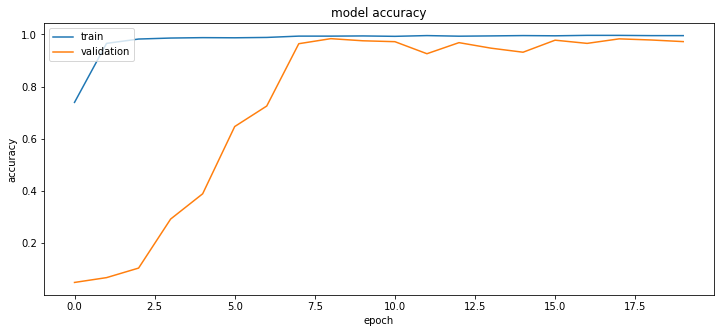

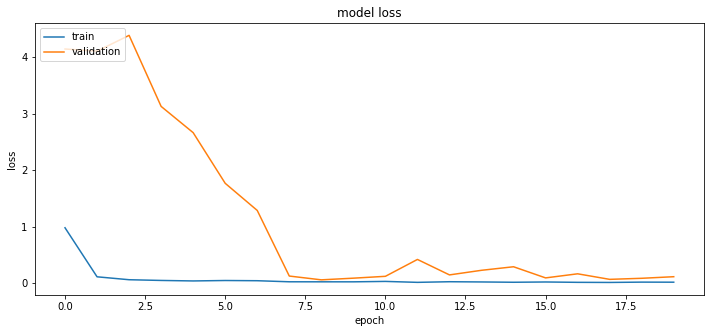

In [11]:
plt.figure(figsize=(12, 5))

plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure(figsize=(12, 5))

plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
loss, acc = model.evaluate(X_test_norm, y_test_array)
print('Accuracy: ', acc, '\nLoss    : ', loss)

246/246 [==============================] - 27s 110ms/step - loss: 0.1158 - accuracy: 0.9723
Accuracy:  0.9723284840583801 
Loss    :  0.11576882749795914


In [13]:
#predikce modelu
model_predictions = model.predict(X_test_norm)
predictions = np.argmax(model_predictions, axis = 1)
actual_values = np.argmax(y_test_array, axis = 1)


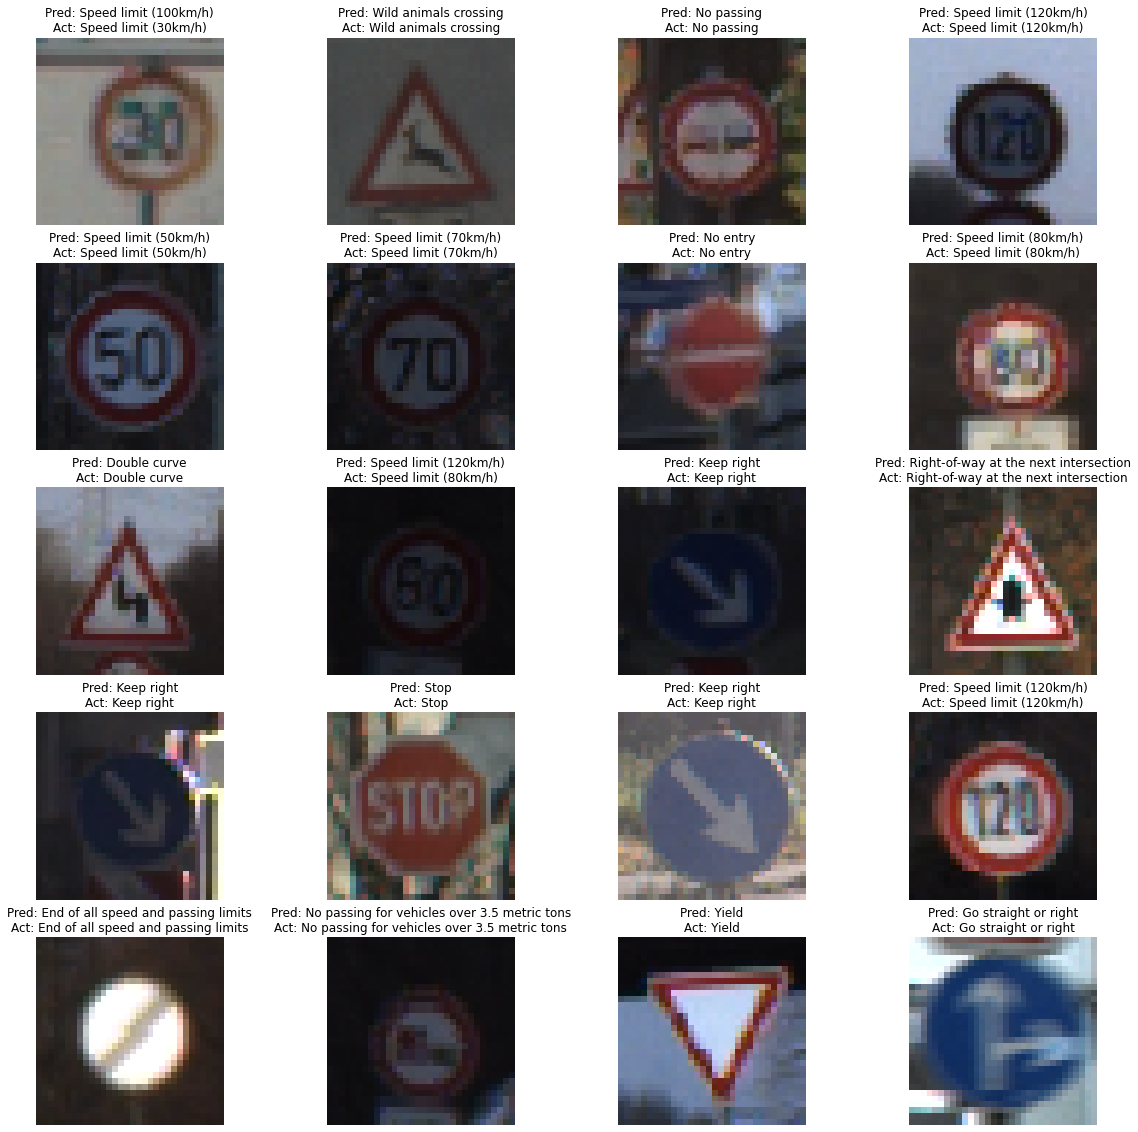

In [22]:
def show_prediction_results(x_test,predict,act,i):
    image = plt.imshow(x_test[i])
    l=plt.title('Pred: ' + category_labels[predict[i]] + '\nAct: ' + category_labels[act[i]])
    ax.grid(False)
    ax.axis('off')    
    return image, l
fig = plt.figure(figsize=(20, 20))


for i in range(20):
    rnd = random.randint(0,len(X_test))
    ax = fig.add_subplot(5, 4, i + 1)
    show_prediction_results(X_test,predictions,actual_values, rnd)

plt.show()


In [15]:
model.save('/kaggle/working/smap_model.h5')


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
loaded = keras.models.load_model('/kaggle/working/smap_model.h5')

In [20]:
model_predictions2 = model.predict(X_test_norm)
predictions2 = np.argmax(model_predictions2, axis = 1)
actual_values2 = np.argmax(y_test_array, axis = 1)

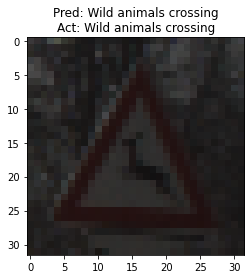

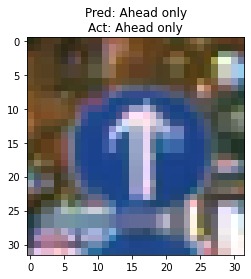

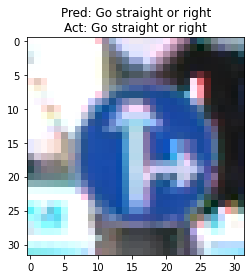

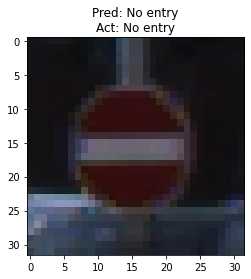

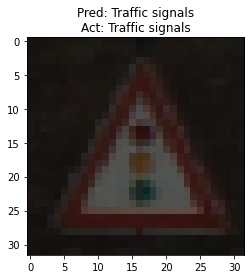

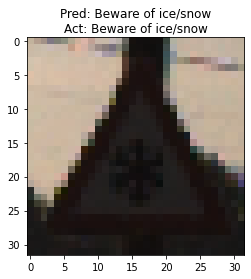

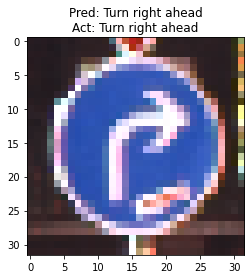

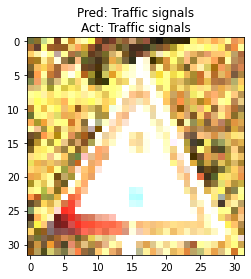

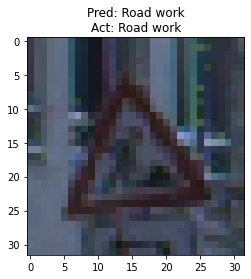

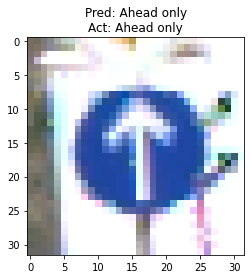

In [25]:
for i in range(10):
    rnd = random.randint(0,len(X_test))
    ax = fig.add_subplot(5, 4, i + 1)
    show_prediction_results(X_test,predictions2, actual_values2, rnd)
    plt.show()
    